<a href="https://colab.research.google.com/github/mann718/DL-lab/blob/main/lab%202/lab2_movie_prediction_202511046.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Task 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import os
import warnings
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"PyTorch version : {torch.__version__}")
print(f"CUDA available  : {torch.cuda.is_available()}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device    : {DEVICE}")

PyTorch version : 2.10.0+cpu
CUDA available  : False
Using device    : cpu


In [3]:
df_raw = pd.read_csv("/content/drive/MyDrive/Glove_models/movies.csv")
print("Raw shape:", df_raw.shape)
df_raw[['genres','keywords','tagline','overview','vote_average']].head(3)

Raw shape: (4803, 24)


,genres,keywords,tagline,overview,vote_average
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Enter the World of Pandora.,"In the 22nd century, a paraplegic Marine is di...",7.2
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"At the end of the world, the adventure begins.","Captain Barbossa, long believed to be dead, ha...",6.9
2,Action Adventure Crime,spy based on novel secret agent sequel mi6,A Plan No One Escapes,A cryptic message from Bond’s past sends him o...,6.3


In [4]:
KNOWN_GENRES = [
    'Science Fiction', 'TV Movie', 'Action', 'Adventure', 'Animation',
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
    'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
    'Thriller', 'War', 'Western'
]

def parse_genres(raw):
    if not isinstance(raw, str):
        return []
    raw = raw.replace('Science Fiction', 'Science_Fiction').replace('TV Movie', 'TV_Movie')
    return [tok.replace('_', ' ') for tok in raw.split() if tok.replace('_', ' ') in KNOWN_GENRES]

df = df_raw[['genres', 'keywords', 'tagline', 'overview', 'vote_average']].copy()
df['genre_list'] = df['genres'].apply(parse_genres)
df = df[df['genre_list'].map(len) > 0].reset_index(drop=True)

for col in ['overview', 'tagline', 'keywords']:
    df[col] = df[col].fillna('')

print(f"Dataset size after filtering: {df.shape}")
print(f"\nVote average stats:")
print(df['vote_average'].describe().round(3))

Dataset size after filtering: (4775, 6)

Vote average stats:
count    4775.000
mean        6.114
std         1.141
min         0.000
25%         5.600
50%         6.200
75%         6.800
max        10.000
Name: vote_average, dtype: float64


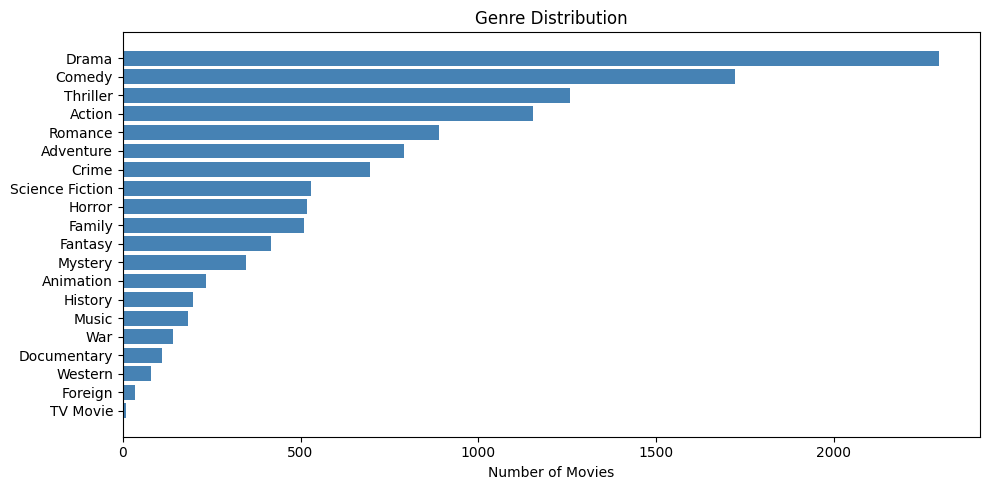

          genre  count
          Drama   2297
         Comedy   1722
       Thriller   1259
         Action   1153
        Romance    890
      Adventure    790
          Crime    696
Science Fiction    530
         Horror    519
         Family    510
        Fantasy    418
        Mystery    347
      Animation    234
        History    197
          Music    183
            War    142
    Documentary    110
        Western     80
        Foreign     34
       TV Movie      8


In [5]:
genre_counts = Counter(chain.from_iterable(df['genre_list']))
genre_df = pd.DataFrame(genre_counts.most_common(), columns=['genre', 'count'])

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(genre_df['genre'], genre_df['count'], color='steelblue')
ax.set_xlabel('Number of Movies')
ax.set_title('Genre Distribution')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(genre_df.to_string(index=False))

In [6]:
# Lowercase
# Remove URLs
# Remove punctuation and digits
# Tokenize by whitespace
# Remove stopwords
# Drop tokens shorter than 3 characters

STOPWORDS = {
    'the','a','an','and','or','but','in','on','at','to','for','of','with',
    'by','from','is','was','are','were','be','been','has','have','had',
    'it','its','this','that','these','those','i','we','you','he','she',
    'they','them','their','our','your','his','her','do','does','did',
    'not','no','so','if','as','up','out','into','about','than','more',
    'also','when','who','which','what','there','where','will','would',
    'could','should','may','might','can','all','just','like','one','two',
    'get','got','make','made','take','after','before','through','over',
    'between','each','only','other','some','such','very','while','much',
    'even','back','still','way','down','then','new','own','same','well',
    'both','being','s','re','ve','d','m','ll','t','her','his','him',
    'she','he','they','them','their','its','our','my','me'
}

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = [t for t in text.split() if t not in STOPWORDS and len(t) > 2]
    return ' '.join(tokens)

for col in ['overview', 'tagline', 'keywords']:
    df[col + '_clean'] = df[col].apply(clean_text)

print("Sample overview (raw):")
print(df['overview'].iloc[0])
print("\nSample overview (cleaned):")
print(df['overview_clean'].iloc[0])

Sample overview (raw):
In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.

Sample overview (cleaned):
century paraplegic marine dispatched moon pandora unique mission becomes torn following orders protecting alien civilization


In [8]:
df['primary_genre'] = df['genre_list'].apply(lambda x: x[0])

train_df, temp_df = train_test_split(df, test_size=0.30, random_state=SEED, stratify=df['primary_genre'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print(f"Train : {len(train_df):,}  ({len(train_df)/len(df)*100:.1f}%)")
print(f"Val   : {len(val_df):,}  ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test  : {len(test_df):,}  ({len(test_df)/len(df)*100:.1f}%)")

Train : 3,342  (70.0%)
Val   : 716  (15.0%)
Test  : 717  (15.0%)


### Task 2

In [ ]:
!unzip /content/drive/MyDrive/Glove_models/glove.2024.wikigiga.200d.zip -d /content/drive/MyDrive/Glove_models

Archive:  /content/drive/MyDrive/Glove_models/glove.2024.wikigiga.200d.zip
  inflating: /content/drive/MyDrive/Glove_models/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt  


In [13]:
GLOVE_PATH = "/content/drive/MyDrive/Glove_models/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt"
GLOVE_DIM = 200

def load_glove(path):
    glove = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            glove[word] = vec
    return glove

print(f"Loading GloVe {GLOVE_DIM}D vectors from '{GLOVE_PATH}' ...")
glove = load_glove(GLOVE_PATH)
print(f"Loaded {len(glove):,} word vectors")

Loading GloVe 200D vectors from '/content/drive/MyDrive/Glove_models/wiki_giga_2024_200_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05_combined.txt' ...
Loaded 1,291,147 word vectors


In [14]:
all_tokens = set()
for col in ['overview_clean', 'tagline_clean', 'keywords_clean']:
    for text in df[col]:
        all_tokens.update(text.split())

covered = sum(1 for t in all_tokens if t in glove)
print(f"Total unique tokens in dataset : {len(all_tokens):,}")
print(f"Tokens found in GloVe          : {covered:,}")
print(f"Embedding coverage             : {100 * covered / len(all_tokens):.2f}%")

Total unique tokens in dataset : 21,910
Tokens found in GloVe          : 21,603
Embedding coverage             : 98.60%


In [15]:
def build_glove_embeddings(texts_train, texts_val, texts_test, glove_dict, dim=100):
    tfidf = TfidfVectorizer(max_features=20000)
    tfidf.fit(texts_train)

    vocab   = tfidf.vocabulary_
    idf_arr = tfidf.idf_

    def embed(texts):
        embs = []
        for text in texts:
            tokens = text.split()
            if not tokens:
                embs.append(np.zeros(dim, dtype=np.float32))
                continue
            counts = Counter(tokens)
            n = len(tokens)
            weighted_sum = np.zeros(dim, dtype=np.float32)
            total_w = 0.0
            for tok, cnt in counts.items():
                if tok in glove_dict and tok in vocab:
                    tf  = cnt / n
                    idf = idf_arr[vocab[tok]]
                    w   = tf * idf
                    weighted_sum += w * glove_dict[tok]
                    total_w += w
            if total_w > 0:
                embs.append(weighted_sum / total_w)
            else:
                present = [glove_dict[t] for t in tokens if t in glove_dict]
                embs.append(np.mean(present, axis=0) if present else np.zeros(dim, dtype=np.float32))
        return np.array(embs, dtype=np.float32)

    return embed(texts_train), embed(texts_val), embed(texts_test), tfidf


emb_cache = {}
tfidf_cache = {}

for col in ['overview_clean', 'tagline_clean', 'keywords_clean']:
    tr, va, te, tfidf_model = build_glove_embeddings(
        train_df[col].tolist(),
        val_df[col].tolist(),
        test_df[col].tolist(),
        glove, GLOVE_DIM
    )
    emb_cache[col]   = {'train': tr, 'val': va, 'test': te}
    tfidf_cache[col] = tfidf_model
    print(f"{col:25s}  train={tr.shape}  val={va.shape}  test={te.shape}")

overview_clean             train=(3342, 200)  val=(716, 200)  test=(717, 200)
tagline_clean              train=(3342, 200)  val=(716, 200)  test=(717, 200)
keywords_clean             train=(3342, 200)  val=(716, 200)  test=(717, 200)


### Task 3


In [16]:
class RegressionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels,     dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class RatingRegressor(nn.Module):
    def __init__(self, input_dim=100):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x).squeeze(-1)

In [17]:
def train_regressor(col_name, epochs=80, lr=1e-3, batch_size=64):
    embs = emb_cache[col_name]
    train_y = train_df['vote_average'].values
    val_y   = val_df['vote_average'].values
    test_y  = test_df['vote_average'].values

    train_ds = RegressionDataset(embs['train'], train_y)
    val_ds   = RegressionDataset(embs['val'],   val_y)
    test_ds  = RegressionDataset(embs['test'],  test_y)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    model     = RatingRegressor(GLOVE_DIM).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5)

    best_val_loss = float('inf')
    best_weights  = None
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = []
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        model.eval()
        v_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                v_losses.append(criterion(model(X), y).item())

        tl = np.mean(epoch_loss)
        vl = np.mean(v_losses)
        train_losses.append(tl)
        val_losses.append(vl)
        scheduler.step(vl)

        if vl < best_val_loss:
            best_val_loss = vl
            best_weights = {k: v.clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_weights)
    model.eval()

    preds, targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            preds.extend(model(X).cpu().numpy())
            targets.extend(y.numpy())

    preds   = np.array(preds)
    targets = np.array(targets)
    mse  = float(np.mean((preds - targets) ** 2))
    rmse = float(np.sqrt(mse))

    return mse, rmse, train_losses, val_losses

In [18]:
global_mean  = train_df['vote_average'].mean()
baseline_mse = float(np.mean((test_df['vote_average'].values - global_mean) ** 2))
baseline_rmse = float(np.sqrt(baseline_mse))
print(f"Baseline → predict global mean = {global_mean:.4f}")
print(f"Baseline MSE  : {baseline_mse:.4f}")
print(f"Baseline RMSE : {baseline_rmse:.4f}")

Baseline → predict global mean = 6.1132
Baseline MSE  : 1.3114
Baseline RMSE : 1.1452


In [19]:
reg_results = {}

for col in ['overview_clean', 'tagline_clean']:
    print(f"\nTraining regressor on '{col}' ...")
    mse, rmse, tr_loss, va_loss = train_regressor(col, epochs=80)
    reg_results[col] = {'MSE': mse, 'RMSE': rmse, 'train_loss': tr_loss, 'val_loss': va_loss}
    print(f"  Test MSE  : {mse:.4f}")
    print(f"  Test RMSE : {rmse:.4f}")


Training regressor on 'overview_clean' ...
  Test MSE  : 1.4095
  Test RMSE : 1.1872

Training regressor on 'tagline_clean' ...
  Test MSE  : 1.4046
  Test RMSE : 1.1851


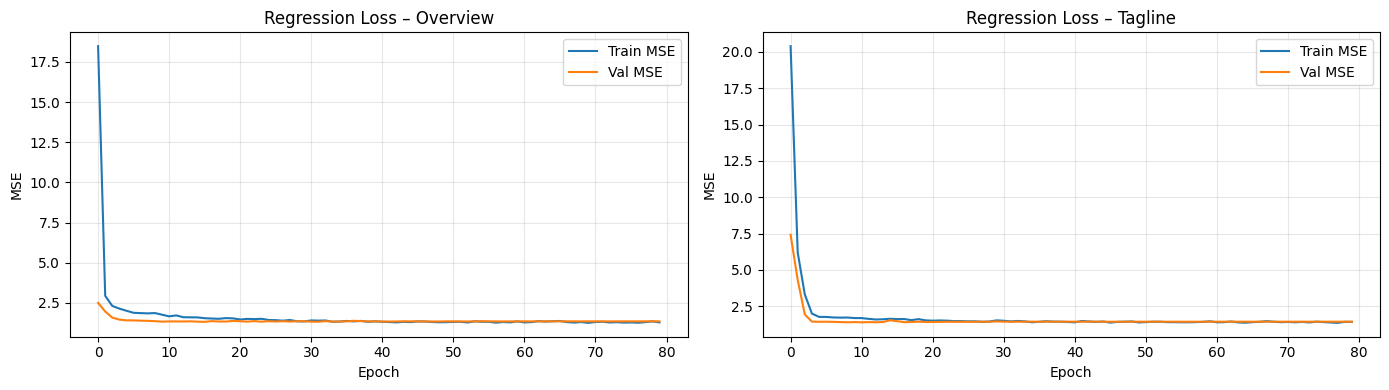

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

col_labels = {'overview_clean': 'Overview', 'tagline_clean': 'Tagline'}

for ax, (col, res) in zip(axes, reg_results.items()):
    ax.plot(res['train_loss'], label='Train MSE')
    ax.plot(res['val_loss'],   label='Val MSE')
    ax.set_title(f"Regression Loss – {col_labels[col]}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
print(f"{'Column':<20} {'MSE':>8} {'RMSE':>8}")
print("-" * 40)
print(f"{'Baseline (mean)':<20} {baseline_mse:>8.4f} {baseline_rmse:>8.4f}")
for col, res in reg_results.items():
    label = col.replace('_clean', '')
    print(f"{label:<20} {res['MSE']:>8.4f} {res['RMSE']:>8.4f}")

Column                    MSE     RMSE
----------------------------------------
Baseline (mean)        1.3114   1.1452
overview               1.4095   1.1872
tagline                1.4046   1.1851


### Task 4

In [22]:
mlb = MultiLabelBinarizer(classes=sorted(genre_counts.keys()))
mlb.fit(df['genre_list'])
NUM_GENRES = len(mlb.classes_)

train_y_multi = mlb.transform(train_df['genre_list']).astype(np.float32)
val_y_multi   = mlb.transform(val_df['genre_list']).astype(np.float32)
test_y_multi  = mlb.transform(test_df['genre_list']).astype(np.float32)

print(f"Number of genres : {NUM_GENRES}")
print(f"Genre classes    : {list(mlb.classes_)}")
print(f"Label matrix shape (train): {train_y_multi.shape}")

Number of genres : 20
Genre classes    : ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Label matrix shape (train): (3342, 20)


In [65]:
class MultiLabelDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels,     dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class GenreClassifier(nn.Module):
    def __init__(self, input_dim=100, num_genres=20):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_genres)
        )

    def forward(self, x):
        return self.network(x)

In [66]:
def train_classifier(col_name, epochs=80, lr=1e-3, batch_size=64, threshold=0.3):
    embs = emb_cache[col_name]

    train_ds = MultiLabelDataset(embs['train'], train_y_multi)
    val_ds   = MultiLabelDataset(embs['val'],   val_y_multi)
    test_ds  = MultiLabelDataset(embs['test'],  test_y_multi)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size)

    pos_weight_vals = []
    for j in range(NUM_GENRES):
        pos = train_y_multi[:, j].sum()
        neg = len(train_y_multi) - pos
        pos_weight_vals.append(neg / max(pos, 1))
    pos_weight = torch.tensor(pos_weight_vals, dtype=torch.float32).to(DEVICE)

    model     = GenreClassifier(GLOVE_DIM, NUM_GENRES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.5)

    best_val_loss = float('inf')
    best_weights  = None
    train_losses, val_losses = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        ep_loss = []
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(X), y)
            loss.backward()
            optimizer.step()
            ep_loss.append(loss.item())

        model.eval()
        v_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                v_losses.append(criterion(model(X), y).item())

        tl = np.mean(ep_loss)
        vl = np.mean(v_losses)
        train_losses.append(tl)
        val_losses.append(vl)
        scheduler.step(vl)

        if vl < best_val_loss:
            best_val_loss = vl
            best_weights = {k: v.clone() for k, v in model.state_dict().items()}

    model.load_state_dict(best_weights)
    model.eval()

    all_preds, all_targets = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(DEVICE)
            logits = model(X)
            probs  = torch.sigmoid(logits).cpu().numpy()
            all_preds.append(probs)
            all_targets.append(y.numpy())

    preds   = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    binary  = (preds >= threshold).astype(int)

    micro_f1 = f1_score(targets, binary, average='micro',  zero_division=0)
    macro_f1 = f1_score(targets, binary, average='macro',  zero_division=0)
    h_loss   = hamming_loss(targets, binary)

    return micro_f1, macro_f1, h_loss, train_losses, val_losses

In [67]:
clf_results = {}

for col in ['keywords_clean', 'overview_clean']:
    print(f"\nTraining classifier on '{col}' ...")
    mi_f1, ma_f1, hl, tr_l, va_l = train_classifier(col, epochs=80)
    clf_results[col] = {
        'Micro-F1': mi_f1, 'Macro-F1': ma_f1,
        'Hamming Loss': hl, 'train_loss': tr_l, 'val_loss': va_l
    }
    print(f"  Micro-F1     : {mi_f1:.4f}")
    print(f"  Macro-F1     : {ma_f1:.4f}")
    print(f"  Hamming Loss : {hl:.4f}")


Training classifier on 'keywords_clean' ...
  Micro-F1     : 0.2946
  Macro-F1     : 0.2474
  Hamming Loss : 0.5621

Training classifier on 'overview_clean' ...
  Micro-F1     : 0.4078
  Macro-F1     : 0.3199
  Hamming Loss : 0.3334


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
col_labels_clf = {'keywords_clean': 'keywords', 'overview_clean': 'Overview'}

for ax, (col, res) in zip(axes, clf_results.items()):
    ax.plot(res['train_loss'], label='Train Loss')
    ax.plot(res['val_loss'],   label='Val Loss')
    ax.set_title(f"Classification Loss – {col_labels_clf[col]}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("BCE Loss")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [27]:
print(f"{'Input Column':<20} {'Micro-F1':>10} {'Macro-F1':>10} {'Hamming Loss':>14}")
print("-" * 58)
for col, res in clf_results.items():
    label = col.replace('_clean', '')
    print(f"{label:<20} {res['Micro-F1']:>10.4f} {res['Macro-F1']:>10.4f} {res['Hamming Loss']:>14.4f}")

Input Column           Micro-F1   Macro-F1   Hamming Loss
----------------------------------------------------------
overview                 0.3675     0.2978         0.3996
keywords                 0.3456     0.2783         0.4344


### Task 5

In [28]:
genre_tokens = {g: [] for g in mlb.classes_}

for _, row in df.iterrows():
    tokens = row['overview_clean'].split()
    for g in row['genre_list']:
        if g in genre_tokens:
            genre_tokens[g].extend(tokens)

genre_freq = {g: Counter(tokens) for g, tokens in genre_tokens.items()}

In [29]:
TOP_N = 10
MIN_FREQ = 3

print("=" * 80)
print("TOP 10 MOST FREQUENT WORDS PER GENRE")
print("=" * 80)

top_rows = []
for genre in sorted(genre_freq.keys()):
    freq = genre_freq[genre]
    top10 = freq.most_common(TOP_N)
    words = [f"{w} ({c})" for w, c in top10]
    top_rows.append({'Genre': genre, 'Top 10 Frequent Words': ', '.join(words)})

top_df = pd.DataFrame(top_rows)
pd.set_option('display.max_colwidth', 120)
print(top_df.to_string(index=False))

TOP 10 MOST FREQUENT WORDS PER GENRE
          Genre                                                                                                          Top 10 Frequent Words
         Action      world (184), must (166), man (151), life (135), young (123), against (114), find (109), war (106), team (101), agent (99)
      Adventure           world (171), must (123), find (113), young (106), life (100), man (81), against (80), save (74), time (71), war (69)
      Animation          world (65), must (40), life (40), find (36), young (36), save (33), adventure (31), old (28), city (27), friends (26)
         Comedy life (310), love (197), man (193), family (183), find (182), world (177), young (176), friends (161), school (157), must (148)
          Crime            life (99), police (93), family (84), man (83), city (65), story (64), find (63), young (62), murder (62), drug (61)
    Documentary       film (42), documentary (34), world (27), life (19), look (16), how (15), time (14),

In [30]:
print("=" * 80)
print("BOTTOM 10 LEAST FREQUENT WORDS PER GENRE  (min frequency >= 3)")
print("=" * 80)

bot_rows = []
for genre in sorted(genre_freq.keys()):
    freq = genre_freq[genre]
    filtered = {w: c for w, c in freq.items() if c >= MIN_FREQ}
    if not filtered:
        bot_rows.append({'Genre': genre, 'Bottom 10 Rare Words': 'N/A'})
        continue
    bottom10 = sorted(filtered.items(), key=lambda x: x[1])[:TOP_N]
    words = [f"{w} ({c})" for w, c in bottom10]
    bot_rows.append({'Genre': genre, 'Bottom 10 Rare Words': ', '.join(words)})

bot_df = pd.DataFrame(bot_rows)
print(bot_df.to_string(index=False))

BOTTOM 10 LEAST FREQUENT WORDS PER GENRE  (min frequency >= 3)
          Genre                                                                                                                       Bottom 10 Rare Words
         Action            believed (3), turner (3), message (3), spectre (3), shape (3), shifting (3), avengers (3), alliances (3), sort (3), closest (3)
      Adventure      dispatched (3), unique (3), orders (3), protecting (3), believed (3), quite (3), message (3), spectre (3), weary (3), transported (3)
      Animation                     tower (3), teen (3), feet (3), deal (3), duo (3), relationship (3), mcqueen (3), head (3), international (3), left (3)
         Comedy humankind (3), mcqueen (3), mater (3), espionage (3), scottish (3), unruly (3), accomplished (3), enormous (3), leaders (3), exploring (3)
          Crime           cryptic (3), battles (3), reputation (3), hunted (3), kyle (3), finest (3), betrayed (3), loved (3), pursuing (3), attempted (3)
    Doc

### Task 6

In [31]:
tfidf_ind = TfidfVectorizer(max_features=15000, min_df=3)
X_all = tfidf_ind.fit_transform(df['overview_clean'])
feature_names = np.array(tfidf_ind.get_feature_names_out())

from sklearn.model_selection import train_test_split as sk_split
X_tr, X_te, _, _ = sk_split(X_all, df.index, test_size=0.2, random_state=SEED)

print(f"TF-IDF matrix shape: {X_all.shape}")
print(f"Vocabulary size    : {len(feature_names)}")

TF-IDF matrix shape: (4775, 7507)
Vocabulary size    : 7507


In [32]:
indicative_results = {}

for genre in sorted(mlb.classes_):
    binary_labels = mlb.transform(df['genre_list'])[:, list(mlb.classes_).index(genre)]

    if binary_labels.sum() < 10:
        continue

    lr = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs', random_state=SEED)
    lr.fit(X_all, binary_labels)

    coefs = lr.coef_[0]
    top_idx = np.argsort(coefs)[-10:][::-1]
    top_words = [(feature_names[i], round(float(coefs[i]), 4)) for i in top_idx]
    indicative_results[genre] = top_words

print("Indicative words computed for", len(indicative_results), "genres")

Indicative words computed for 19 genres


In [33]:
print("=" * 80)
print("TOP 10 GENRE-INDICATIVE WORDS (by Logistic Regression Coefficient)")
print("=" * 80)

for genre, words in sorted(indicative_results.items()):
    word_strs = [f"{w} ({c:.3f})" for w, c in words]
    print(f"\n{genre}:")
    print("  " + ", ".join(word_strs))

TOP 10 GENRE-INDICATIVE WORDS (by Logistic Regression Coefficient)

Action:
  agent (2.757), cop (2.608), criminals (2.361), hero (2.137), ruthless (2.043), mission (1.931), against (1.896), forces (1.879), kidnapped (1.863), target (1.855)

Adventure:
  adventure (3.226), bond (2.611), world (1.790), earth (1.762), mission (1.662), jungle (1.622), against (1.607), must (1.578), captain (1.522), dragon (1.492)

Animation:
  adventure (2.557), animated (2.426), world (1.756), save (1.638), human (1.519), named (1.459), shrek (1.433), stop (1.375), dragon (1.347), animals (1.266)

Comedy:
  comedy (3.929), big (2.275), wedding (2.055), guy (1.850), show (1.825), movie (1.789), doesn (1.610), comic (1.570), christmas (1.559), boss (1.515)

Crime:
  police (3.734), cop (3.136), drug (2.896), murder (2.689), criminal (2.633), fbi (2.630), detective (2.518), mafia (2.338), mob (2.260), gangster (2.182)

Documentary:
  documentary (4.823), look (2.362), film (2.127), interviews (1.494), filmm